# Credit card default Prediction

* **Importing libraries**

In [1]:
# creating virtual env
!python3 -m venv env

In [2]:
!source env/bin/activate
!which python

python not found


In [33]:
# importing all required libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats, special
import shap
from lime.lime_tabular import LimeTabularExplainer

In [8]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [40]:
# importing ML libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold, StratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

In [9]:
# Display all rows and columns of a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

* **Describe dataset**

In [10]:
# Reading the training dataset
df = pd.read_csv('/content/cs-training.csv')

In [12]:
# (No.of rows, No.of columns)
df.shape

(150000, 12)

In [ ]:
# A general information about the datatype of an attribute and missing values (if any)
df.info()
# notice the MonthlyIncome and NumberOfDependents

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [ ]:
# What percentage of data is missing in each feature?
round(df.isnull().sum(axis=0)/len(df), 2) * 100

Unnamed: 0                               0.0
SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           20.0
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       3.0
dtype: float64

In [ ]:
# preview of the data
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [24]:
# What percentage of the observations are unique?
df['Unnamed: 0'].nunique()/len(df)*100

100.0

In [25]:
# rename the first column
df.rename(columns = {'Unnamed: 0': 'CustomerID'}, inplace=True)

In [30]:
# What are the values of the target variable?
df['SeriousDlqin2yrs'].unique()

array([1, 0])

In [32]:
# since 1 is customers delinquency. What percentage of customers defaulted in the dataset?
df['SeriousDlqin2yrs'].sum()/len(df)*100

6.683999999999999

In [36]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [37]:
df.describe()

,CustomerID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


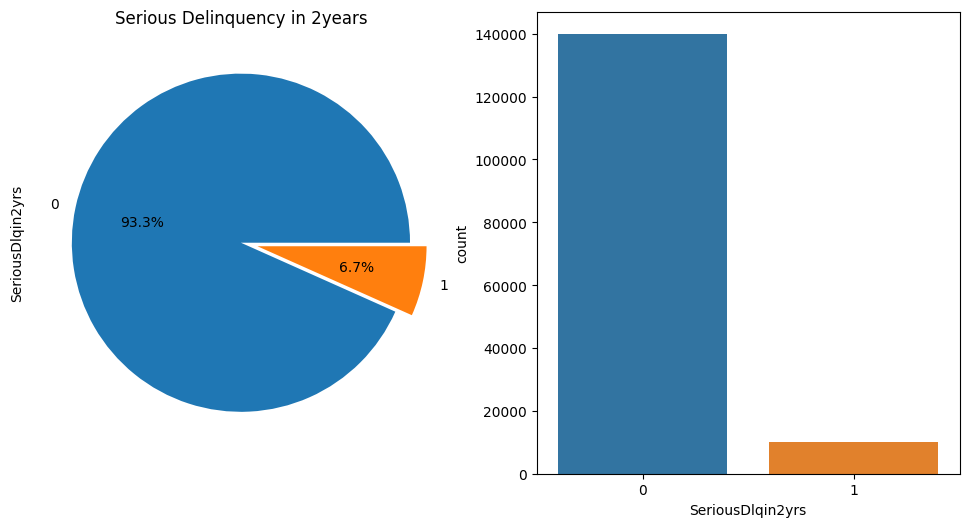

In [35]:
# Plot the analysis so far
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax = axes[0])
axes[0].set_title('Serious Delinquency in 2years')
sns.countplot(x='SeriousDlqin2yrs', data=df, ax=axes[1])
plt.show()

This is class imbalance problem as class `1` has significantly less observations

Splitting the dataset into train-test (80/20) split

In [38]:
X = df.drop(columns= ['SeriousDlqin2yrs'], axis=1)
y = df['SeriousDlqin2yrs']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify= y)

In [42]:
# Training dataset shape
X_train.shape, y_train.shape

((120000, 11), (120000,))

In [43]:
# Testing dataset shape
X_test.shape, y_test.shape

((30000, 11), (30000,))

In [45]:
# what is the event rate in the training, test, and entire dataset?
print("Event rate in training dataset:", np.mean(y_train)
*100)
print("Event rate in training dataset:", np.mean(y_test)*100)
print("Event rate in training dataset:", np.mean(df['SeriousDlqin2yrs'])*100)

Event rate in training dataset: 6.684166666666666
Event rate in training dataset: 6.683333333333333
Event rate in training dataset: 6.683999999999999


Event rate/Default rate is maintained in the training and test dataset after splitting the entire dataset with the random state

In [46]:
train = pd.concat([X_train, y_train], axis= 1)
train.shape

(120000, 12)

In [47]:
test = pd.concat([X_test, y_test], axis= 1)
test.shape

(30000, 12)

`Univariate analysis` and `Bivariate analysis` are two types of statistical analysis used to understand data in machine learning.   
Both types of analysis are important in machine learning because they help us understand the data we are working with. By understanding the data, we can build better models that make more accurate predictions or classifications. For example, we can identify which variables are most important to include in our model and which ones we can ignore.


In [50]:
# Univariate Analysis using Numerical dataset
def plot_hist_boxplot(column):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize= (12, 5))
  sns.distplot(train[train[column].notnull()][column], ax= ax1)
  sns.boxplot(y = train[train[column].notnull()][column], ax= ax2)
  print("Skewness:", skew(train[train[column].notnull()][column]))
  print("Kurtosis:", kurtosis(train[train[column].notnull()][column]))
  plt.show()

def plot_count_boxplot(column):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
  sns.countplot(train[train[column].notnull()][column], ax=ax1)
  sns.boxplot(train[train[column].notnull()][column], ax= ax2)
  print("Skewness:", skew(train[train[column].notnull()][column]))
  print("Kurtosis:", kurtosis(train[train[column].notnull()][column]))
  plt.show()

Skewness: 100.53820302006339
Kurtosis: 15559.574874151434


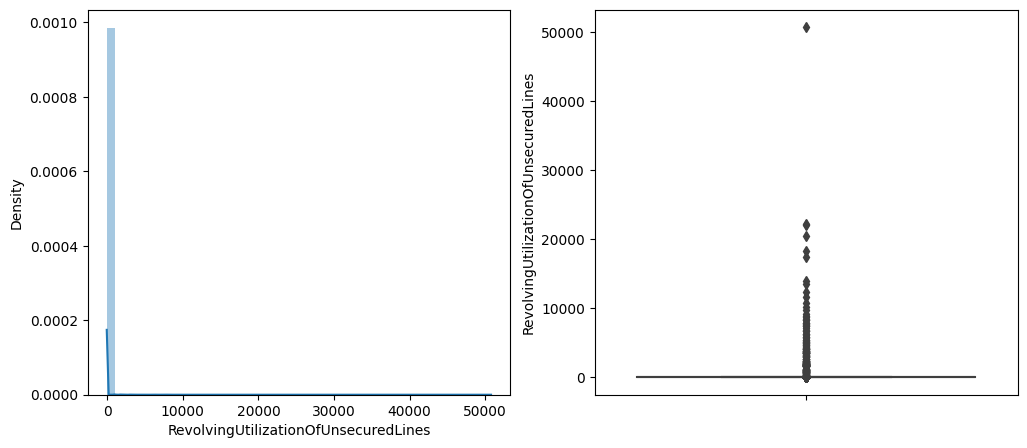

In [51]:
plot_hist_boxplot('RevolvingUtilizationOfUnsecuredLines')

Skewness: 0.18619637326841987
Kurtosis: -0.498427938670404


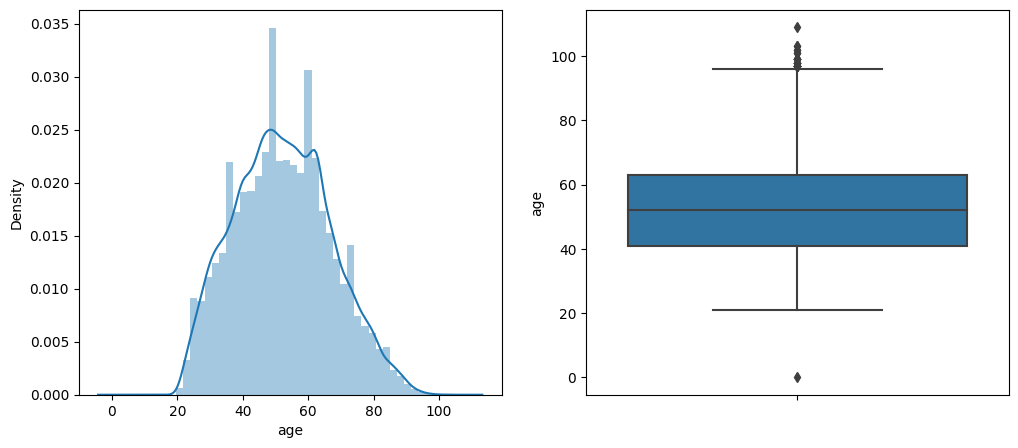

In [52]:
plot_hist_boxplot('age')

Skewness: 99.14282373943726
Kurtosis: 14370.263366125106


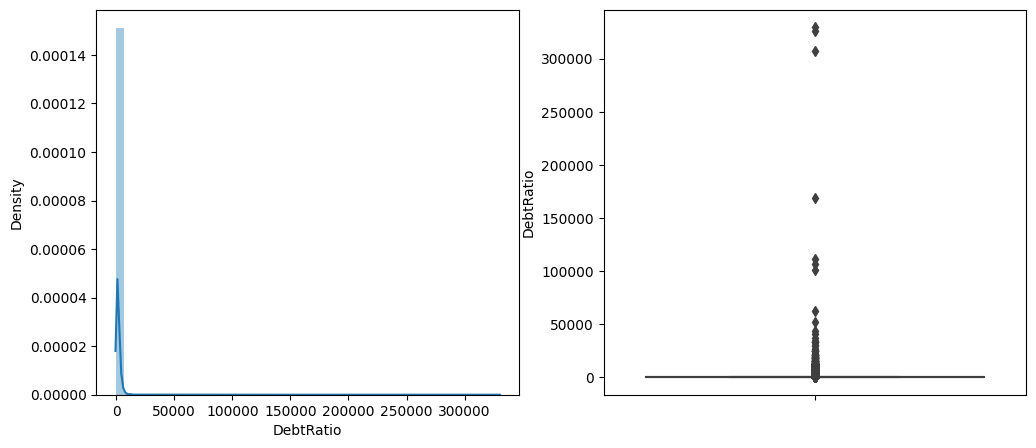

In [53]:
plot_hist_boxplot("DebtRatio")

Skewness: 122.58760175290827
Kurtosis: 21861.235154793823


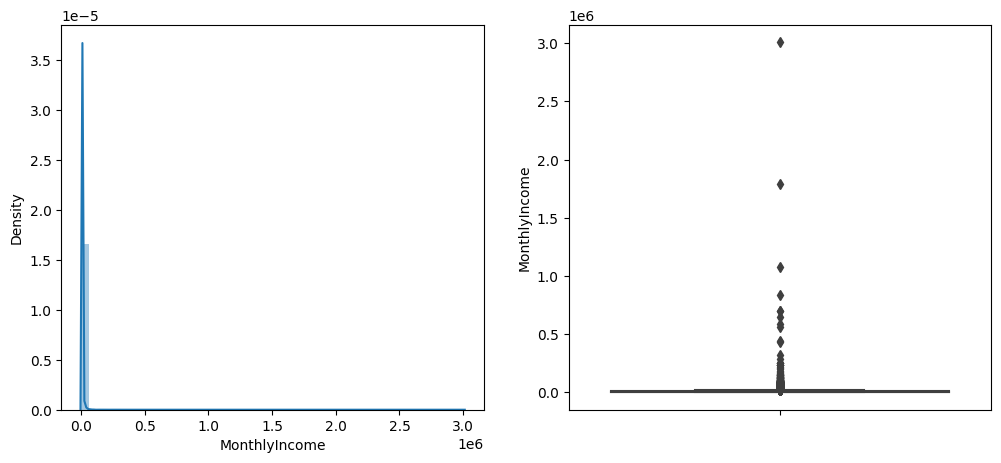

In [54]:
plot_hist_boxplot('MonthlyIncome')

Skewness: 1.228631935202937
Kurtosis: 3.1788690218615834


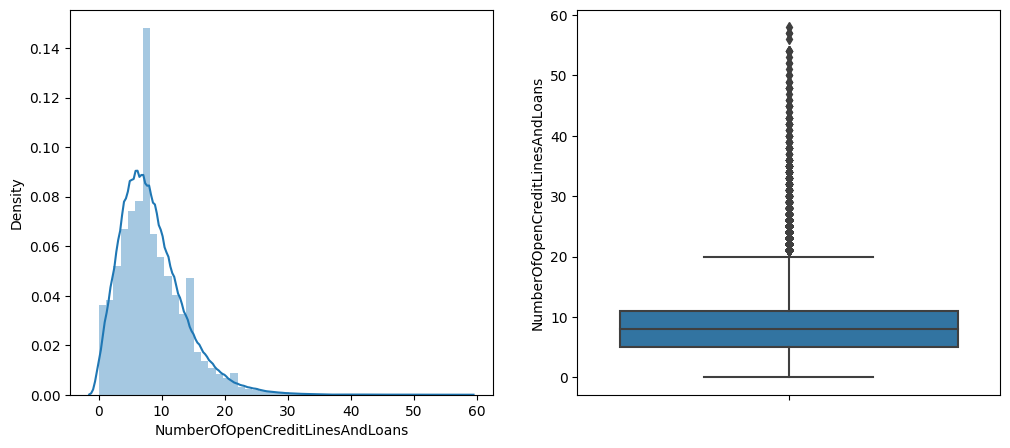

In [55]:
plot_hist_boxplot('NumberOfOpenCreditLinesAndLoans')

Skewness: 3.752640736788862
Kurtosis: 71.08765036833758


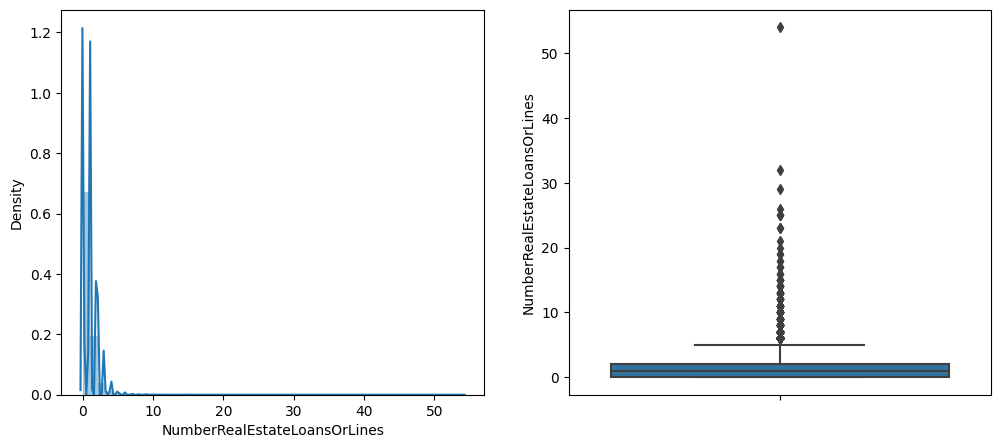

In [56]:
plot_hist_boxplot('NumberRealEstateLoansOrLines')

Skewness: 1.5985560487376647
Kurtosis: 3.1785476956522656


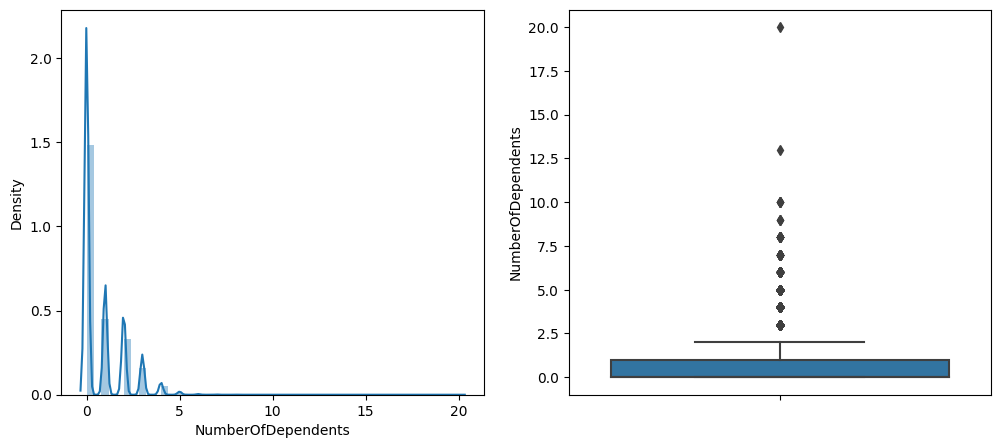

In [59]:
plot_hist_boxplot('NumberOfDependents')

Skewness: 22.656444686738023
Kurtosis: 525.1798137690517


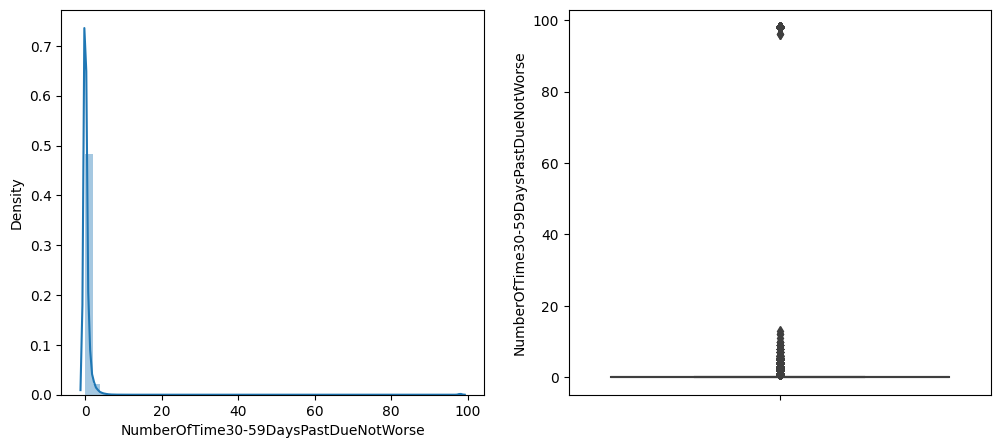

In [60]:
plot_hist_boxplot('NumberOfTime30-59DaysPastDueNotWorse')

Skewness: 23.393598377179494
Kurtosis: 548.632426633495


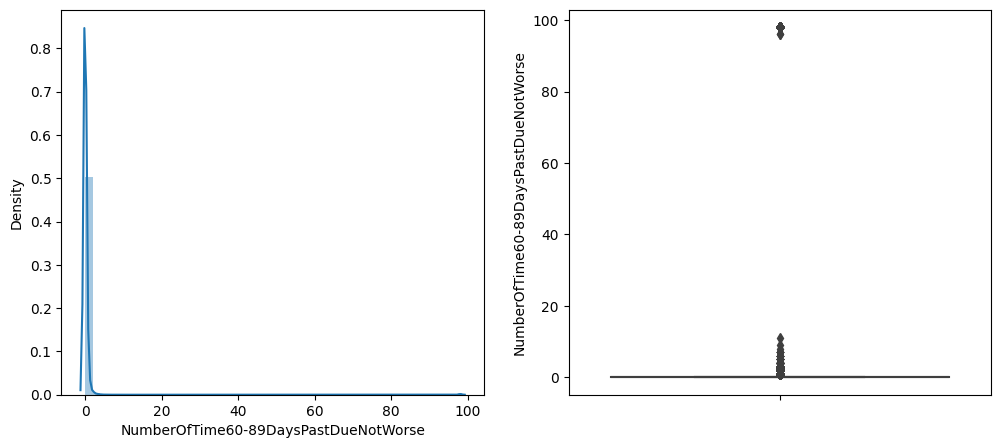

In [61]:
plot_hist_boxplot('NumberOfTime60-89DaysPastDueNotWorse')

Skewness: 23.155584699487473
Kurtosis: 540.8745184818808


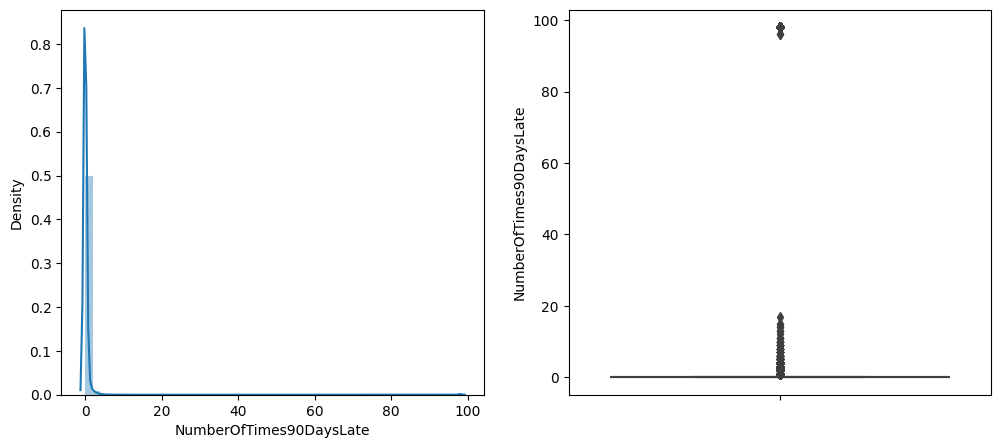

In [62]:
plot_hist_boxplot('NumberOfTimes90DaysLate')

In [63]:
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [64]:
skewness = []
kurt = []
for col in cols_for_stats:
  skewness.append(skew(train[train[col].notnull()][col]))
  kurt.append(kurtosis(train[train[col].notnull()][col]))

stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt}, index=[col for col in cols_for_stats])
stats.sort_values(by=['Skewness'], ascending= False)

,Skewness,Kurtosis
MonthlyIncome,122.587602,21861.235155
RevolvingUtilizationOfUnsecuredLines,100.538203,15559.574874
DebtRatio,99.142824,14370.263366
NumberOfTime60-89DaysPastDueNotWorse,23.393598,548.632427
NumberOfTimes90DaysLate,23.155585,540.874518
NumberOfTime30-59DaysPastDueNotWorse,22.656445,525.179814
NumberRealEstateLoansOrLines,3.752641,71.087650
NumberOfDependents,1.598556,3.178548
NumberOfOpenCreditLinesAndLoans,1.228632,3.178869
age,0.186196,-0.498428


From the above analysis, data distribution in the columns are highly right skewed with very high kurtosis value showing extreme outliers in those columns, except the age which is little normally distributed.